In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time

%matplotlib inline

In [2]:
from thor import __version__
print(f"THOR: {__version__}")
from difi import __version__
print(f"difi: {__version__}")

THOR: 1.1.dev225+gad9fec1.d20210506
difi: 1.1rc3


In [3]:
OUT_DIR = "pipeline"
SAVE = False
THREADS = 60

In [4]:
DATA_DIR = "/home/moeyensj/projects/thor/thor_data/ztf/"
observations = pd.read_csv(
    os.path.join(DATA_DIR, "ztf_observations_610_624.csv"), 
    sep=" ", 
    index_col=False, 
    low_memory=False
)
observations.sort_values(by="jd", inplace=True)

observations["observatory_code"] = ["I41" for i in range(len(observations))]    
observations["mjd_utc"] = Time(
    observations["jd"], 
    scale="utc", 
    format="jd"
).utc.mjd

In [5]:
from thor import preprocessObservations

column_mapping = {
    "obs_id" : "candid",
    "mjd" : "mjd_utc",
    "RA_deg" : "ra",
    "Dec_deg" : "decl",
    "RA_sigma_deg" : None,
    "Dec_sigma_deg" : None,
    "observatory_code" : "observatory_code",
    "obj_id" : "ssnamenr",
}   
mjd_scale = "utc"
astrometric_errors = {
    "I41" : [
        0.1/3600, 
        0.1/3600
    ]
}

preprocessed_observations, preprocessed_associations = preprocessObservations(
    observations,
    column_mapping,
    mjd_scale=mjd_scale,
    astrometric_errors=astrometric_errors
)

/home/moeyensj/projects/thor/thor/thor/data_processing.py:146: UserWarning: No astrometric error columns defined in the column_mapping dictionary.
Using 'astrometric_errors' parameter to assign errors...

  warnings.warn(
/home/moeyensj/projects/thor/thor/thor/data_processing.py:256: UserWarning: Observation IDs should be of type string, converting...
  warnings.warn(warn)
/home/moeyensj/projects/thor/thor/thor/data_processing.py:265: UserWarning: Object IDs should be of type string, converting...
  warnings.warn(warn)


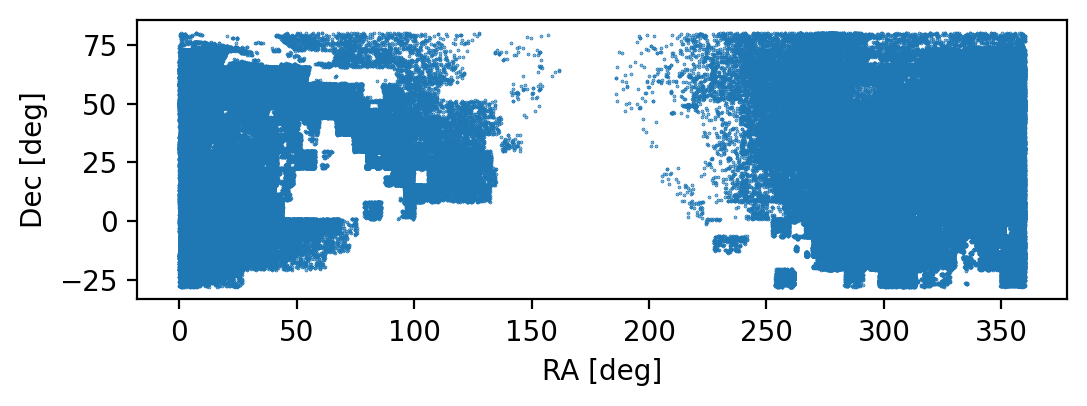

In [6]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(*preprocessed_observations[["RA_deg", "Dec_deg"]].values.T, s=0.1)
ax.set_xlabel("RA [deg]")
ax.set_ylabel("Dec [deg]")
ax.set_aspect("equal")

In [7]:
preprocessed_observations

obs_id       mjd_utc      RA_deg    Dec_deg  RA_sigma_deg  \
0       610130484415010015  58364.130486  255.347544 -23.059466      0.000028   
1       610130481215010007  58364.130486  255.077637 -26.542553      0.000028   
2       610130481215015021  58364.130486  254.708502 -26.721381      0.000028   
3       610130483515015056  58364.130486  261.287334 -24.006969      0.000028   
4       610130483515015069  58364.130486  261.062061 -23.963993      0.000028   
...                    ...           ...         ...        ...           ...   
827541  624525841115010001  58378.525845   88.190274  37.450669      0.000028   
827542  624525845615015001  58378.525845   88.726105  44.074660      0.000028   
827543  624525842315010002  58378.525845   90.988261  39.132977      0.000028   
827544  624525840015015062  58378.525845   92.511387  37.966540      0.000028   
827545  624525840215015030  58378.525845   91.314483  37.285546      0.000028   

        Dec_sigma_deg observatory_code  
0            0.000028              I41  
1            0.000028              I41  
2            0.000028              I41  
3            0.000028              I41  
4            0.000028              I41  
...               ...              ...  
827541       0.000028              I41  
827542       0.000028              I41  
827543       0.000028              I41  
827544       0.000028              I41  
827545       0.000028              I41  

[827546 rows x 7 columns]

In [8]:
preprocessed_associations

obs_id obj_id
0       610130484415010015   None
1       610130481215010007   None
2       610130481215015021   None
3       610130483515015056   None
4       610130483515015069   None
...                    ...    ...
827541  624525841115010001   None
827542  624525845615015001  43423
827543  624525842315010002   None
827544  624525840015015062  61549
827545  624525840215015030  57242

[827546 rows x 2 columns]

In [9]:
# might need to install ray : its not part of the requirements.txt
#import ray
#if not ray.is_initialized():
#    ray.init(num_cpus=THREADS)

### Discoverable

In [10]:
min_obs = 5
contamination_percentage = 20.0
min_arc_length = 1.0

In [11]:
from difi import analyzeObservations

analysis_observations = preprocessed_observations.merge(
    preprocessed_associations,
    on="obs_id",
    how="left"
)
analysis_observations.loc[analysis_observations["obj_id"] == "None", "obj_id"] = ["unknown{:d}".format(i) for i in range(len(analysis_observations[analysis_observations["obj_id"] == "None"]))]

column_mapping = {
    "obs_id" : "obs_id",
    "truth" : "obj_id",
    "linkage_id" : "cluster_id"
}

all_truths, findable_observations, summary = analyzeObservations(
    analysis_observations, 
    column_mapping=column_mapping,
    min_obs=min_obs
)

In [12]:
summary

class  num_members  num_obs  findable
0   All       635058   827546     21542

In [13]:
all_truths

obj_id  num_obs  findable
0             453781      100         1
1             244616       94         1
2             488511       92         1
3             363390       86         1
4             415813       86         1
...              ...      ...       ...
635053  unknown99995        1         0
635054  unknown99996        1         0
635055  unknown99997        1         0
635056  unknown99998        1         0
635057  unknown99999        1         0

[635058 rows x 3 columns]

### Defining a Test Orbit

In [14]:
from thor.orbits import Orbits

t0 = Time([
    preprocessed_observations["mjd_utc"].min()], 
    scale="utc", 
    format="mjd"
)

test_orbit = Orbits.fromHorizons(["2010 EG43"], t0)

In [15]:
from thor.backend import PYOORB

observers = {}
for observatory_code in preprocessed_observations["observatory_code"].unique():
    observers[observatory_code] = Time(
        preprocessed_observations[preprocessed_observations["observatory_code"].isin([observatory_code])]["mjd_utc"].unique(),
        format="mjd",
        scale="utc"
    )

In [16]:
backend = PYOORB()    
propagated = backend.propagateOrbits(
    test_orbit, 
    observers["I41"], 
    threads=THREADS
)

In [17]:
ephemeris = backend.generateEphemeris(
    test_orbit, 
    observers, 
    threads=THREADS
)

In [18]:
from thor.orbits import generateEphemeris
from thor.orbits import propagateOrbits

In [19]:
propagated = propagateOrbits(
    test_orbit, 
    observers["I41"], 
    backend="PYOORB",
    threads=THREADS
)

In [20]:
ephemeris = generateEphemeris(
    test_orbit, 
    observers, 
    backend="PYOORB",
    threads=THREADS
)

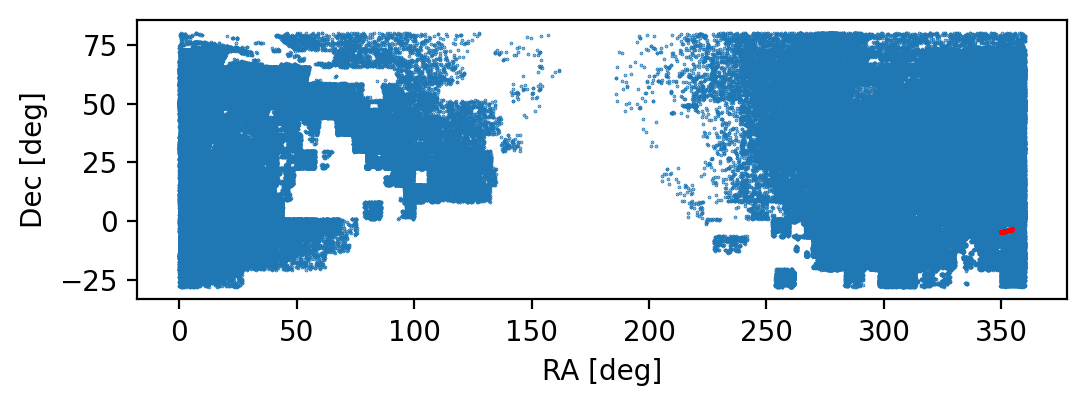

In [21]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(*preprocessed_observations[["RA_deg", "Dec_deg"]].values.T, s=0.1)
ax.set_xlabel("RA [deg]")
ax.set_ylabel("Dec [deg]")
ax.set_aspect("equal")
ax.scatter(*ephemeris[["RA_deg", "Dec_deg"]].values.T, s=0.1, c="r")

In [22]:
#import shutil

#shutil.rmtree(OUT_DIR)
#os.mkdir(OUT_DIR)

### 1) Range and Shift Observations

In [23]:
from thor import rangeAndShift

if not os.path.exists(os.path.join(OUT_DIR, "projected_observations.csv")):
    projected_observations = rangeAndShift(
        preprocessed_observations, 
        test_orbit, 
        cell_area=1000,
        backend="PYOORB",
        backend_kwargs={},
        threads=THREADS,
    )
    if SAVE:
        projected_observations.to_csv(
            os.path.join(OUT_DIR, "projected_observations.csv"), 
            index=False
        )

else: 
    projected_observations = pd.read_csv(
        os.path.join(OUT_DIR, "projected_observations.csv"), 
        dtype={
            "obs_id" : str
        }
    )

09:38:04.536 [INFO] thor - Running range and shift...
09:38:04.537 [INFO] thor - Assuming r = [ 2.36288976 -0.49785673 -0.02688165] au
09:38:04.538 [INFO] thor - Assuming v = [0.00036147 0.00879701 0.00117943] au per day
09:38:24.623 [INFO] thor - Found 70598 observations.
09:38:24.625 [INFO] thor - Range and shift completed in 20.087 seconds.


In [24]:
from difi import analyzeObservations

analysis_observations = projected_observations.merge(
    preprocessed_associations,
    on="obs_id",
    how="left"
)
analysis_observations.loc[analysis_observations["obj_id"] == "None", "obj_id"] = ["unknown{:d}".format(i) for i in range(len(analysis_observations[analysis_observations["obj_id"] == "None"]))]

column_mapping = {
    "obs_id" : "obs_id",
    "truth" : "obj_id",
    "linkage_id" : "cluster_id"
}

all_truths, findable_observations, summary = analyzeObservations(
    analysis_observations, 
    column_mapping=column_mapping,
    min_obs=min_obs
)

In [25]:
summary

class  num_members  num_obs  findable
0   All        30008    70598      4813

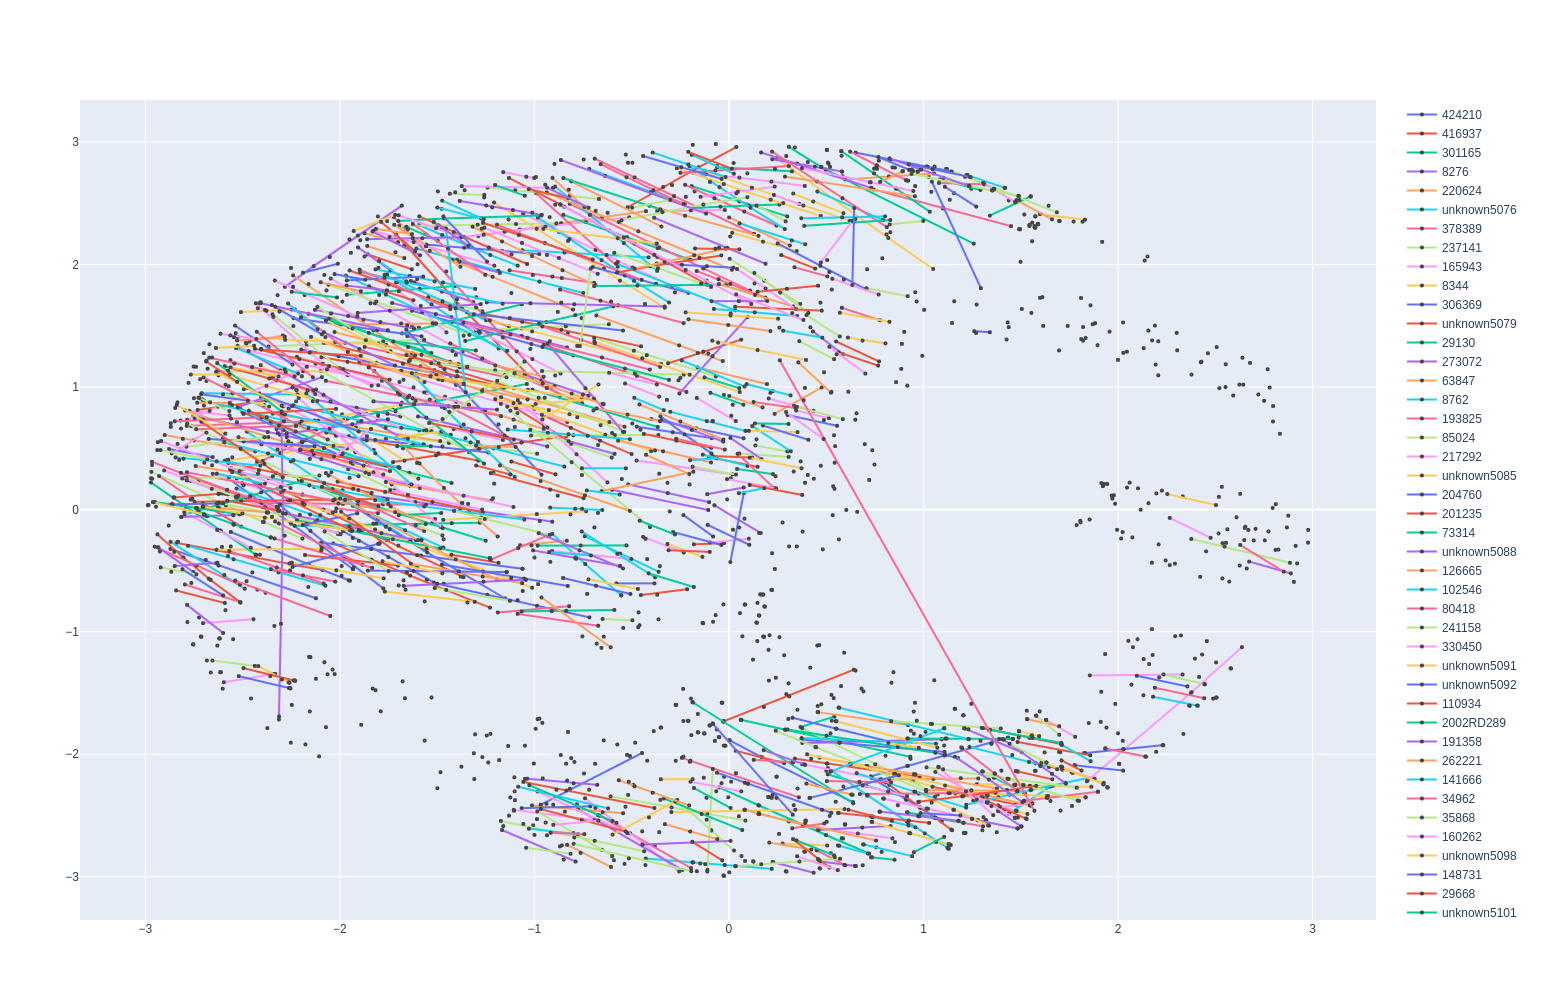

In [26]:
from thor.plotting import plotProjections
from thor.plotting import plotProjections3D

theta_radius = np.linalg.norm(analysis_observations[["theta_x_deg", "theta_y_deg"]].values, axis=1)

fig = plotProjections(
    analysis_observations.iloc[theta_radius < 3], 
    color_by_object=True
)

### 2) Cluster and Link Observations

In [27]:
from thor import clusterAndLink

if not os.path.exists(os.path.join(OUT_DIR, "clusters.csv")):
    clusters, cluster_members = clusterAndLink(
        projected_observations,
        vx_range=[-0.1, 0.1], 
        vy_range=[-0.1, 0.1],
        vx_bins=100, # normally 300 x  300
        vy_bins=100,
        eps=0.005,
        min_samples=min_obs, 
        min_arc_length=min_arc_length,
        threads=THREADS,
        identify_subsets=False
    )
    if SAVE:
        clusters.to_csv(
            os.path.join(OUT_DIR, "clusters.csv"), 
            index=False
        )
        cluster_members.to_csv(
            os.path.join(OUT_DIR, "cluster_members.csv"),
            index=False
        )
else: 
    clusters = pd.read_csv(
        os.path.join(OUT_DIR, "clusters.csv")
    )
    cluster_members = pd.read_csv(
        os.path.join(OUT_DIR, "cluster_members.csv"), 
        dtype={
            "obs_id" : str
        }
    )

09:38:27.558 [INFO] thor - Running velocity space clustering...
09:38:27.560 [INFO] thor - Max sample distance: 0.005
09:38:27.560 [INFO] thor - Minimum samples: 5
09:39:46.002 [INFO] thor - Clustering completed in 78.443 seconds.
09:39:46.004 [INFO] thor - Restructuring clusters...
09:39:52.348 [INFO] thor - Restructuring completed in 6.343 seconds.
09:39:52.349 [INFO] thor - Found 43599 clusters.
09:39:52.349 [INFO] thor - Clustering and restructuring completed in 84.790 seconds.


In [28]:
clusters

cluster_id  vtheta_x  vtheta_y  arc_length
0      bc2d3af241a341768f52e9c8495072c6 -0.100000      -0.1    8.989201
1      c5f9b767ec794b18840a4cea70d4afcc -0.095960      -0.1    5.969873
2      1585953070b14b9d979269bb8a1ddc67 -0.095960      -0.1    3.009618
3      dcda41cb12d3467585395baa25fabd99 -0.093939      -0.1    3.079722
4      2d8a0f2aa190496abcd62c71ba672089 -0.093939      -0.1   12.019190
...                                 ...       ...       ...         ...
43594  52b8c883dd0049d1b2dc96be63945339  0.093939       0.1    8.981447
43595  741d714f70454b2fbf4ca5ff4a5a2714  0.093939       0.1    2.961424
43596  eebb8fd9dcd84183aed1f98b29bd1535  0.093939       0.1    3.065961
43597  e6d0d2edd6ff470eab97dd54bed9a73a  0.095960       0.1    9.047928
43598  5ad4df502f514038af9eb4b5b06f2840  0.095960       0.1    6.016945

[43599 rows x 4 columns]

In [29]:
cluster_members

cluster_id              obs_id
0       bc2d3af241a341768f52e9c8495072c6  612370532815015030
1       bc2d3af241a341768f52e9c8495072c6  612400502815015018
2       bc2d3af241a341768f52e9c8495072c6  621309990615015020
3       bc2d3af241a341768f52e9c8495072c6  621311366115015003
4       bc2d3af241a341768f52e9c8495072c6  621336710615015030
...                                  ...                 ...
233792  5ad4df502f514038af9eb4b5b06f2840  617321081015015016
233793  5ad4df502f514038af9eb4b5b06f2840  617335415615015000
233794  5ad4df502f514038af9eb4b5b06f2840  617351421015015010
233795  5ad4df502f514038af9eb4b5b06f2840  623308411415015000
233796  5ad4df502f514038af9eb4b5b06f2840  623336661415015001

[233797 rows x 2 columns]

In [30]:
from difi import analyzeLinkages

column_mapping = {
    "obs_id" : "obs_id",
    "truth" : "obj_id",
    "linkage_id" : "cluster_id"
}

all_clusters, all_truths_clusters, summary_clusters = analyzeLinkages(
    analysis_observations, 
    cluster_members,
    all_truths=all_truths,
    min_obs=min_obs, 
    contamination_percentage=contamination_percentage, 
    column_mapping=column_mapping
)

In [31]:
summary_clusters

class  num_members  num_obs  completeness  findable  found  findable_found  \
0   All        30008    70598     64.450447      4813   3102            3102   

   findable_missed  not_findable_found  not_findable_missed  ...  \
0             1711                   0                25195  ...   

   unique_in_partial_linkages_only  unique_in_pure_and_partial_linkages  \
0                               46                                  326   

   unique_in_partial_linkages  unique_in_partial_contaminant_linkages  \
0                         372                                    4918   

   unique_in_mixed_linkages  obs_in_pure_linkages  \
0                      6625                 33802   

   obs_in_pure_complete_linkages  obs_in_partial_linkages  \
0                           7580                    70588   

   obs_in_partial_contaminant_linkages  obs_in_mixed_linkages  
0                                17453                 111954  

[1 rows x 31 columns]

In [32]:
summary_clusters

class  num_members  num_obs  completeness  findable  found  findable_found  \
0   All        30008    70598     64.450447      4813   3102            3102   

   findable_missed  not_findable_found  not_findable_missed  ...  \
0             1711                   0                25195  ...   

   unique_in_partial_linkages_only  unique_in_pure_and_partial_linkages  \
0                               46                                  326   

   unique_in_partial_linkages  unique_in_partial_contaminant_linkages  \
0                         372                                    4918   

   unique_in_mixed_linkages  obs_in_pure_linkages  \
0                      6625                 33802   

   obs_in_pure_complete_linkages  obs_in_partial_linkages  \
0                           7580                    70588   

   obs_in_partial_contaminant_linkages  obs_in_mixed_linkages  
0                                17453                 111954  

[1 rows x 31 columns]

### 3) Initial Orbit Determination

In [33]:
from thor.orbits import initialOrbitDetermination

if not os.path.exists(os.path.join(OUT_DIR, "iod_orbits.csv")):

    iod_orbits, iod_orbit_members = initialOrbitDetermination(
        projected_observations, 
        cluster_members, 
        rchi2_threshold=100000,
        min_obs=min_obs,
        min_arc_length=min_arc_length,
        contamination_percentage=contamination_percentage,
        backend="PYOORB", 
        threads=THREADS,
        iterate=False,
        identify_subsets=False
    )
    if SAVE:
        iod_orbits.to_csv(
            os.path.join(OUT_DIR,"iod_orbits.csv"), 
            index=False
        )
        iod_orbit_members.to_csv(
            os.path.join(OUT_DIR,"iod_orbit_members.csv"), 
            index=False
        )
    
else:
    iod_orbits = pd.read_csv(
        os.path.join(OUT_DIR, "iod_orbits.csv"), 
        dtype={
            "obs_id" : str
        }
    )
    iod_orbit_members = pd.read_csv(
        os.path.join(OUT_DIR, "iod_orbit_members.csv"),  
        dtype={
            "obs_id" : str
        }
    )

09:39:53.251 [INFO] thor.orbits.iod - Running initial orbit determination...
09:42:08.028 [INFO] thor.orbits.iod - Found 8804 initial orbits.
09:42:08.254 [INFO] thor.orbits.iod - Initial orbit determination completed in 135.002 seconds.


In [34]:
iod_orbit_members = iod_orbit_members[(iod_orbit_members["outlier"] == 0)]

for df in [iod_orbits, iod_orbit_members]:
    df.reset_index(
        inplace=True,
        drop=True
    )

In [35]:
from difi import analyzeLinkages

column_mapping = {
    "obs_id" : "obs_id",
    "truth" : "obj_id",
    "linkage_id" : "orbit_id"
}

all_iod_orbits, all_truths_iod, summary_iod = analyzeLinkages(
    analysis_observations, 
    iod_orbit_members,
    all_truths=all_truths,
    min_obs=min_obs, 
    contamination_percentage=contamination_percentage, 
    column_mapping=column_mapping
)

In [36]:
summary_clusters

class  num_members  num_obs  completeness  findable  found  findable_found  \
0   All        30008    70598     64.450447      4813   3102            3102   

   findable_missed  not_findable_found  not_findable_missed  ...  \
0             1711                   0                25195  ...   

   unique_in_partial_linkages_only  unique_in_pure_and_partial_linkages  \
0                               46                                  326   

   unique_in_partial_linkages  unique_in_partial_contaminant_linkages  \
0                         372                                    4918   

   unique_in_mixed_linkages  obs_in_pure_linkages  \
0                      6625                 33802   

   obs_in_pure_complete_linkages  obs_in_partial_linkages  \
0                           7580                    70588   

   obs_in_partial_contaminant_linkages  obs_in_mixed_linkages  
0                                17453                 111954  

[1 rows x 31 columns]

In [37]:
summary_iod

class  num_members  num_obs  completeness  findable  found  findable_found  \
0   All        30008    70598     64.263453      4813   3093            3093   

   findable_missed  not_findable_found  not_findable_missed  ...  \
0             1720                   0                25195  ...   

   unique_in_partial_linkages_only  unique_in_pure_and_partial_linkages  \
0                               21                                  139   

   unique_in_partial_linkages  unique_in_partial_contaminant_linkages  \
0                         160                                     186   

   unique_in_mixed_linkages  obs_in_pure_linkages  \
0                      4825                 33660   

   obs_in_pure_complete_linkages  obs_in_partial_linkages  \
0                           7570                      921   

   obs_in_partial_contaminant_linkages  obs_in_mixed_linkages  
0                                  205                  16940  

[1 rows x 31 columns]

### 4) Differential Correction

In [38]:
from thor.orbits import differentialCorrection

od_orbits, od_orbit_members = differentialCorrection(
    iod_orbits,
    iod_orbit_members,
    projected_observations, 
    rchi2_threshold=10.0,
    min_obs=min_obs,
    min_arc_length=min_arc_length,
    contamination_percentage=contamination_percentage,
    delta=1e-6, 
    method="central",
    max_iter=10,
    threads=THREADS,
    fit_epoch=False,
    backend="PYOORB"
)

09:42:09.268 [INFO] thor.orbits.od - Running differential correction...
09:44:54.131 [INFO] thor.orbits.od - Differentially corrected 5716 orbits.
09:44:54.132 [INFO] thor.orbits.od - Differential correction completed in 164.863 seconds.


In [39]:
column_mapping = {
    "obs_id" : "obs_id",
    "truth" : "obj_id",
    "linkage_id" : "orbit_id"
}

all_od_orbits, all_truths_od, summary_od = analyzeLinkages(
    analysis_observations, 
    od_orbit_members, 
    all_truths=all_truths,
    min_obs=min_obs, 
    contamination_percentage=0.0, 
    column_mapping=column_mapping
)


In [40]:
summary_clusters

class  num_members  num_obs  completeness  findable  found  findable_found  \
0   All        30008    70598     64.450447      4813   3102            3102   

   findable_missed  not_findable_found  not_findable_missed  ...  \
0             1711                   0                25195  ...   

   unique_in_partial_linkages_only  unique_in_pure_and_partial_linkages  \
0                               46                                  326   

   unique_in_partial_linkages  unique_in_partial_contaminant_linkages  \
0                         372                                    4918   

   unique_in_mixed_linkages  obs_in_pure_linkages  \
0                      6625                 33802   

   obs_in_pure_complete_linkages  obs_in_partial_linkages  \
0                           7580                    70588   

   obs_in_partial_contaminant_linkages  obs_in_mixed_linkages  
0                                17453                 111954  

[1 rows x 31 columns]

In [41]:
summary_iod

class  num_members  num_obs  completeness  findable  found  findable_found  \
0   All        30008    70598     64.263453      4813   3093            3093   

   findable_missed  not_findable_found  not_findable_missed  ...  \
0             1720                   0                25195  ...   

   unique_in_partial_linkages_only  unique_in_pure_and_partial_linkages  \
0                               21                                  139   

   unique_in_partial_linkages  unique_in_partial_contaminant_linkages  \
0                         160                                     186   

   unique_in_mixed_linkages  obs_in_pure_linkages  \
0                      4825                 33660   

   obs_in_pure_complete_linkages  obs_in_partial_linkages  \
0                           7570                      921   

   obs_in_partial_contaminant_linkages  obs_in_mixed_linkages  
0                                  205                  16940  

[1 rows x 31 columns]

In [42]:
summary_od

class  num_members  num_obs  completeness  findable  found  findable_found  \
0   All        30008    70598     63.910243      4813   3076            3076   

   findable_missed  not_findable_found  not_findable_missed  ...  \
0             1737                   0                25195  ...   

   unique_in_partial_linkages_only  unique_in_pure_and_partial_linkages  \
0                                0                                    0   

   unique_in_partial_linkages  unique_in_partial_contaminant_linkages  \
0                           0                                       0   

   unique_in_mixed_linkages  obs_in_pure_linkages  \
0                       638                 33530   

   obs_in_pure_complete_linkages  obs_in_partial_linkages  \
0                           7539                        0   

   obs_in_partial_contaminant_linkages  obs_in_mixed_linkages  
0                                    0                   1219  

[1 rows x 31 columns]

### 5) Orbit Merging and Extension

In [43]:
from thor.orbits import mergeAndExtendOrbits

odp_orbits, odp_orbit_members = mergeAndExtendOrbits(
    od_orbits,
    od_orbit_members[(od_orbit_members["outlier"] == 0)],
    projected_observations, 
    min_obs=min_obs,
    eps=1/3600, 
    rchi2_threshold=10.0,
    contamination_percentage=0.0,
    delta=1e-8,
    max_iter=5,
    method="central",
    fit_epoch=False,
    orbits_chunk_size=100,
    observations_chunk_size=100000,
    threads=THREADS,
    backend="PYOORB", 
)

09:44:54.695 [INFO] thor.orbits.attribution - Running orbit extension and merging...
09:44:54.759 [INFO] thor.orbits.attribution - Running observation attribution...
09:45:05.798 [INFO] thor.orbits.attribution - Attributed 23393 observations to 5716 orbits.
09:45:05.799 [INFO] thor.orbits.attribution - Attribution completed in 11.023 seconds.
09:46:08.120 [INFO] thor.orbits.od - Running differential correction...
09:47:27.525 [INFO] thor.orbits.od - Differentially corrected 7295 orbits.
09:47:27.526 [INFO] thor.orbits.od - Differential correction completed in 79.405 seconds.
09:47:27.720 [INFO] thor.orbits.attribution - There are 58 observations that appear in more than one orbit.
09:47:27.764 [INFO] thor.orbits.attribution - Running observation attribution...
09:47:33.740 [INFO] thor.orbits.attribution - Attributed 15099 observations to 1910 orbits.
09:47:33.742 [INFO] thor.orbits.attribution - Attribution completed in 5.971 seconds.
09:47:48.925 [INFO] thor.orbits.od - Running differ

In [44]:
column_mapping = {
    "obs_id" : "obs_id",
    "truth" : "obj_id",
    "linkage_id" : "orbit_id"
}

all_odp_orbits, all_truths_odp, summary_odp = analyzeLinkages(
    analysis_observations, 
    odp_orbit_members, 
    all_truths=all_truths,
    min_obs=min_obs, 
    contamination_percentage=0.0, 
    column_mapping=column_mapping
)


In [45]:
summary_od

class  num_members  num_obs  completeness  findable  found  findable_found  \
0   All        30008    70598     63.910243      4813   3076            3076   

   findable_missed  not_findable_found  not_findable_missed  ...  \
0             1737                   0                25195  ...   

   unique_in_partial_linkages_only  unique_in_pure_and_partial_linkages  \
0                                0                                    0   

   unique_in_partial_linkages  unique_in_partial_contaminant_linkages  \
0                           0                                       0   

   unique_in_mixed_linkages  obs_in_pure_linkages  \
0                       638                 33530   

   obs_in_pure_complete_linkages  obs_in_partial_linkages  \
0                           7539                        0   

   obs_in_partial_contaminant_linkages  obs_in_mixed_linkages  
0                                    0                   1219  

[1 rows x 31 columns]

In [46]:
summary_odp

class  num_members  num_obs  completeness  findable  found  findable_found  \
0   All        30008    70598     63.744027      4813   3068            3068   

   findable_missed  not_findable_found  not_findable_missed  ...  \
0             1745                   0                25195  ...   

   unique_in_partial_linkages_only  unique_in_pure_and_partial_linkages  \
0                                0                                    0   

   unique_in_partial_linkages  unique_in_partial_contaminant_linkages  \
0                           0                                       0   

   unique_in_mixed_linkages  obs_in_pure_linkages  \
0                       524                 22875   

   obs_in_pure_complete_linkages  obs_in_partial_linkages  \
0                          21780                        0   

   obs_in_partial_contaminant_linkages  obs_in_mixed_linkages  
0                                    0                    555  

[1 rows x 31 columns]